##Using CNN's to classify Cats vs Dogs Dataset

Creating a model to classify cat vs dog image datasets and look into how data augmentation can help improve the model.

Outline:
1. Get Data
2. Process Data
3. Defining and Training the Model
4. Tackle Overfitting with Data Augmentation

In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers, losses

### Get Data

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-01-27 14:29:12--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.97.45.22, 2600:1409:9800:98c::317f, 2600:1409:9800:984::317f
Connecting to download.microsoft.com (download.microsoft.com)|104.97.45.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   246MB/s    in 3.3s    

2023-01-27 14:29:15 (237 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [ ]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


In [ ]:
source_path_cats

'/tmp/PetImages/Cat'

In [ ]:
# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

#create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets
  
  Args:
    root_path (string) - the base directory path to create subdirectories from
  
  Returns:
    None
  """  

  paths = []
  paths.append(os.path.join(root_path, 'training'))
  os.makedirs(paths[0])
  paths.append(os.path.join(root_path, 'validation'))
  os.makedirs(paths[1])

  subfiles = ['cats', 'dogs']
  for path in paths:
    for afile in subfiles:
      pathname = os.path.join(path, afile)
      os.makedirs(pathname)
  
create_train_val_dirs(root_path=root_dir)

In [ ]:
# Test our create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs


Now have to code the split_data function which takes in the following arguments:

* SOURCE_DIR: directory containing the files

* TRAINING_DIR: directory that a portion of the files will be copied to (will be used for training)

* VALIDATION_DIR: directory that a portion of the files will be copied to (will be used for validation)

* SPLIT_SIZE: determines the portion of images used for training.

The files should be randomized, so that the training set is a random sample of the files, and the validation set is made up of the remaining files.

For example, if SOURCE_DIR is PetImages/Cat, and SPLIT_SIZE is .9 then 90% of the images in PetImages/Cat will be copied to the TRAINING_DIR directory and 10% of the images will be copied to the VALIDATION_DIR directory.

**NOTE**: All images should be checked before the copy, so if they have a zero file length, they will be omitted from the copying process. If this is the case then our function should print out a message such as "filename is zero length, so ignoring.". We should perform this check before the split so that only non-zero images are considered when doing the actual split.


In [ ]:
os.path.getsize(os.path.join(source_path_cats, os.listdir(source_path_cats)[0]))

24374

###Process Data

In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training
    
  Returns:
    None
  """

  fileList = os.listdir(SOURCE_DIR)

  #Omitting file with zero length
  newFileList = []
  for afile in fileList:
    if os.path.getsize(os.path.join(SOURCE_DIR, afile)):
      newFileList.append(afile)
    else:
      print(f'{afile} is zero length, so ignoring.')

  #Randomizing file
  random.sample(newFileList, len(newFileList))

  #splitting the file
  mid = int(len(newFileList)*SPLIT_SIZE)

  #copying the file 
  for i, afile in enumerate(newFileList):
    if i < mid: 
      copyfile(os.path.join(SOURCE_DIR, afile), os.path.join(TRAINING_DIR, afile))
    else:
      copyfile(os.path.join(SOURCE_DIR, afile), os.path.join(VALIDATION_DIR, afile))


In [ ]:
# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


Now that we have successfully organized the data in a way that can be easily fed to Keras' ImageDataGenerator, it is time for us to code the generators that will yield batches of images, both for training and validation. For this, will use train_val_generators function below.

**NOTE**: The images in this dataset come in a variety of resolutions. Luckily, the flow_from_directory method allows us to standarize this by defining a tuple called target_size that will be used to convert each image to this target resolution. For this exercise, we use a target_size of (150, 150).


In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropiate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class 
  validation_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropiate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=16,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


### Defining and Training the Model

One last step before training is to define the architecture of the model that will be trained.

**create_model** function below will return the desired Keras' Sequential model.
.


In [ ]:
def create_model():

  model = tf.keras.models.Sequential([ 
        #Add convolutional and max pooling
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        #Add convolutional and max pooling
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        #Add convolutional and max pooling
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        #Add the dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate=0.001),
                metrics=['accuracy']) 
    
  return model

In [ ]:
# Get the untrained model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)


Epoch 1/15
480/704 [===================>..........] - ETA: 22s - loss: 0.6862 - accuracy: 0.6086

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

704/704 [==============================] - 85s 115ms/step - loss: 0.6445 - accuracy: 0.6445 - val_loss: 0.5251 - val_accuracy: 0.7504
Epoch 2/15
704/704 [==============================] - 81s 115ms/step - loss: 0.4814 - accuracy: 0.7758 - val_loss: 0.4502 - val_accuracy: 0.7948
Epoch 3/15
704/704 [==============================] - 78s 111ms/step - loss: 0.4117 - accuracy: 0.8141 - val_loss: 0.4000 - val_accuracy: 0.8228
Epoch 4/15
704/704 [==============================] - 78s 111ms/step - loss: 0.3638 - accuracy: 0.8463 - val_loss: 0.3979 - val_accuracy: 0.8216
Epoch 5/15
704/704 [==============================] - 78s 111ms/step - loss: 0.3226 - accuracy: 0.8655 - val_loss: 0.3941 - val_accuracy: 0.8324
Epoch 6/15
704/704 [==============================] - 79s 112ms/step - loss: 0.2847 - accuracy: 0.8867 - val_loss: 0.4640 - val_accuracy: 0.8396
Epoch 7/15
704/704 [==============================] - 78s 111ms/step - loss: 0.2668 - accuracy: 0.8984 - val_loss: 0.4575 - val_accuracy: 0.8

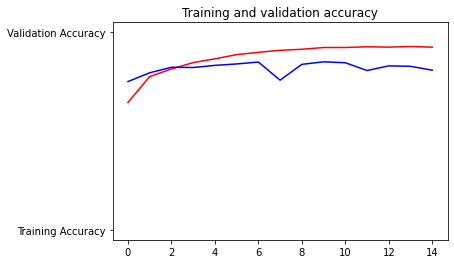

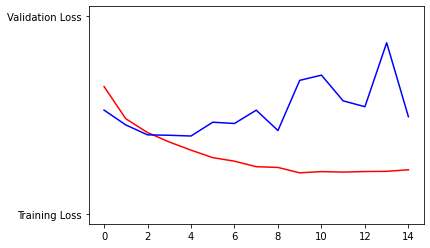

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

###Tackle Overfitting with Data Augmentation



In [ ]:
def new_train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=45,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=16,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

  return train_generator, validation_generator


In [ ]:
train_generator_1, validation_generator_1 = new_train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


Will use the same model as earlier

In [ ]:
# Get the untrained model
new_model = create_model()

# Train the model
history = model.fit(train_generator_1,
                    epochs=25,
                    verbose=1,
                    validation_data=validation_generator_1)


Epoch 1/25
398/704 [===============>..............] - ETA: 1:12 - loss: 0.6440 - accuracy: 0.6559

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

704/704 [==============================] - 171s 243ms/step - loss: 0.6249 - accuracy: 0.6770 - val_loss: 0.3869 - val_accuracy: 0.8344
Epoch 2/25
704/704 [==============================] - 170s 241ms/step - loss: 0.5664 - accuracy: 0.7286 - val_loss: 0.4601 - val_accuracy: 0.8104
Epoch 3/25
704/704 [==============================] - 173s 246ms/step - loss: 0.5380 - accuracy: 0.7459 - val_loss: 0.4302 - val_accuracy: 0.8384
Epoch 4/25
704/704 [==============================] - 171s 243ms/step - loss: 0.5138 - accuracy: 0.7573 - val_loss: 0.4278 - val_accuracy: 0.8376
Epoch 5/25
704/704 [==============================] - 171s 243ms/step - loss: 0.4928 - accuracy: 0.7719 - val_loss: 0.4778 - val_accuracy: 0.8060
Epoch 6/25
704/704 [==============================] - 173s 246ms/step - loss: 0.4812 - accuracy: 0.7796 - val_loss: 0.4636 - val_accuracy: 0.7772
Epoch 7/25
704/704 [==============================] - 170s 241ms/step - loss: 0.4812 - accuracy: 0.7793 - val_loss: 0.3559 - val_accura

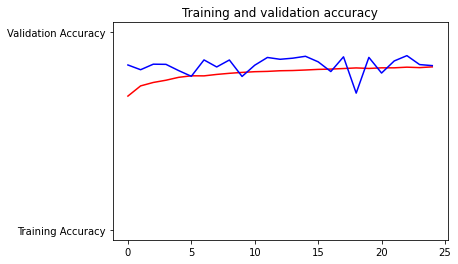

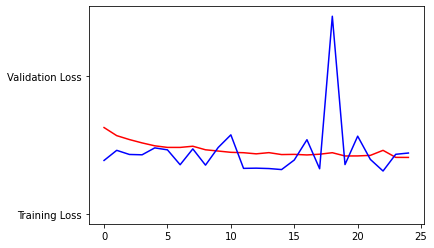

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

By using Data Augmentation, able to increase validation accuracy from 80% to 83%. Data Augmentation help reducing overfitting and makes the model more robust.